In [1]:
# my modules imports
from model import SEIR
from utils import draw_input_params

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [2]:
debug = True
seed = 1111

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.44777459960438104),
             ('pIH', 0.18875055527924495),
             ('pIU', 0.020307202696216567),
             ('pHD', 0.13104769418698442),
             ('pHU', 0.10020098399490976),
             ('pUD', 0.2471189448783151),
             ('NI', 8.951166880633519),
             ('NH', 22.359158732407092),
             ('NU', 14.954680759619642),
             ('R0', 3.2922126744045577),
             ('mu', 0.018855441784553242),
             ('N', 50),
             ('t0', 10),
             ('Im0', 47.1459765189812),
             ('lambda1', 0.003134189119522501)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09881985306407182),
             ('gIH', 0.011644610401521123),
             ('gIU', 0.0012528146653254559),
             ('gHD', 0.005861029735302406),
             ('gHU', 0.004481429073164532),
             ('gHR', 0.03438194303365658),
             

In [4]:
ykeys = {
        'S' : 0,
        'Im' : 1,
        'Ip' : 2,
        'Rm' : 3,
        'RI' : 4,
        'H' : 5,
        'U' : 6,
        'RH' : 7,
        'D' : 8,
        'DR' : 9
    }

def extract_int_value(solution, step_in_day):
    # start:end:step
    sol, period = (solution[::int(1/step_in_day),:], 1) if step_in_day < 1 else (solution, step_in_day) # extraction of integer day value
    return sol, period # period = 1, if we have a value for each day, if one value every two days, equals 2 etc.

def post_processing(solution, period):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    # we suppose that the first element is the 0th day.
    max_it = np.argmax(solution[:,ykeys['U']])
    max_U = solution[max_it,ykeys['U']]
    max_time = max_it*period
    return int(max_time), int(max_U)
    
def plot_solution(seed = None):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    
    fcn = model.get_fcn()
    y_ini = model.get_state()
    # in number of days
    step_in_day = 0.1 # 1/step_in_day should be an integer
    tini = 0.
    tend = 200.0 # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini)  
    sol, period = extract_int_value(solution, step_in_day)
    
    t = np.linspace(tini, tend, int((tend-tini)/period)) # t for printing where 1 day = 1 value.

    max_time, max_U = post_processing(sol, period)
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))

    names = ['Susceptible', 'Infected - Not detected', 'Infected - Detected', 'Recovered - Not detected', \
             'Recovered - Detected - No Hospital', 'In Hospital', 'In Intensive Care', 'Recovered - from Hospital', 'Dead', 'Number of new cases (DR)']
    colors = ['blue', 'orange', 'red', 'cyan', 'green', 'pink', 'purple', 'brown', 'black', 'yellow'] # https://www.geeksforgeeks.org/python-bokeh-colors-class/
    
    fig_sol = figure(x_range=(tini, tend), plot_height=450, plot_width=900, title="Solution")
    
    
    legend_it = []
    for idx, name in enumerate(names):
        c = fig_sol.x(t, sol[:,idx], line_width=1, color = colors[idx], alpha=0.9, muted_color=colors[idx], muted_alpha=0.01) # legend_label="Speed")
        legend_it.append((name, [c]))
        
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')
    #show(column(fig_sol_speed), notebook_handle=True)

    show(fig_sol, notebook_handle=True)
    

In [8]:
plot_solution(seed = 1000)

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.7267947927323049),
             ('pIH', 0.06725104146866087),
             ('pIU', 0.03850848593047074),
             ('pHD', 0.14821914014279983),
             ('pHU', 0.18724745351820354),
             ('pUD', 0.242466536184544),
             ('NI', 8.162838499076356),
             ('NH', 18.971944613457058),
             ('NU', 12.3313219734838),
             ('R0', 3.3208703621265308),
             ('mu', 0.024495764107072285),
             ('N', 40),
             ('t0', 4),
             ('Im0', 39.823258653075285),
             ('lambda1', 0.002640308679571459)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.11896669847213927),
             ('gIH', 0.0022508511868136113),
             ('gIU', 0.0012888554491663439),
             ('gHD', 0.00781254337194649),
             ('gHU', 0.009869702728595695),
             ('gHR', 0.03502716352374517),
             ('gU

In [9]:
def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        
        step_in_day = 0.1 # 0.1 : 10 points per day
        tini = 0.
        tend = 200.0
        number_of_steps = int((tend-tini)/step_in_day)

        t = np.linspace(tini,tend,number_of_steps)

        rtol, atol = 1e-3, 1e-6 # default values
        
        solution = odeint(func = fcn, t = t, y0 = y_ini)
    
        sol, period = extract_int_value(solution, step_in_day)
        max_time, max_U = post_processing(sol, period)
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [10]:
N=1000
list_U, list_times = Monte_Carlo_Umax(N=N)

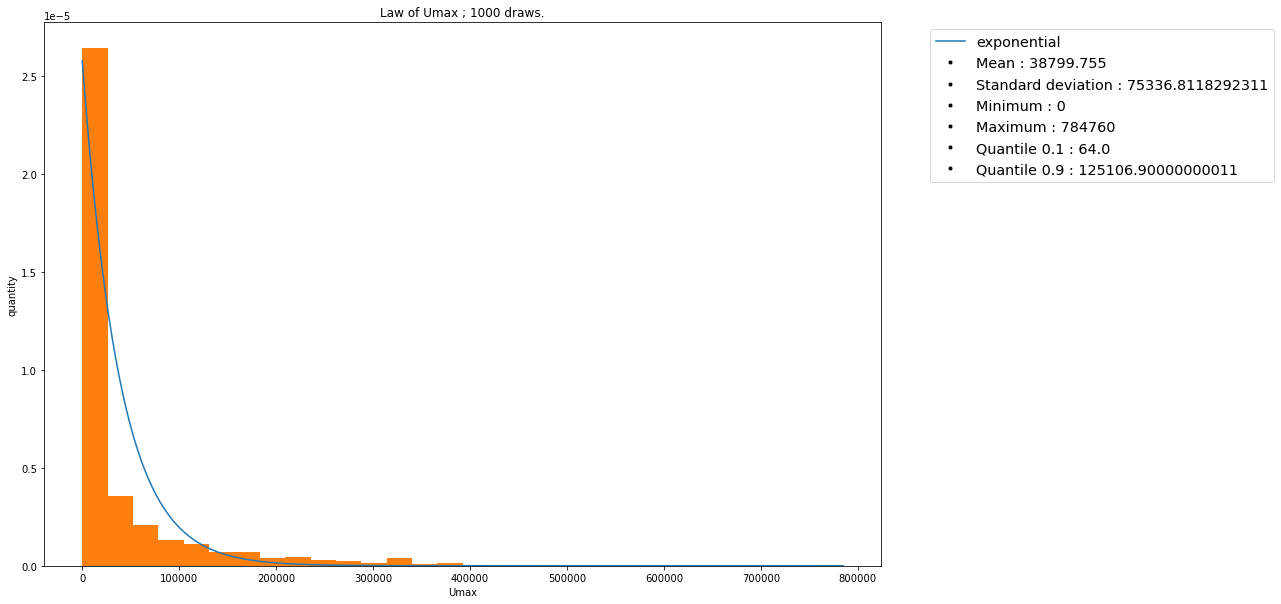

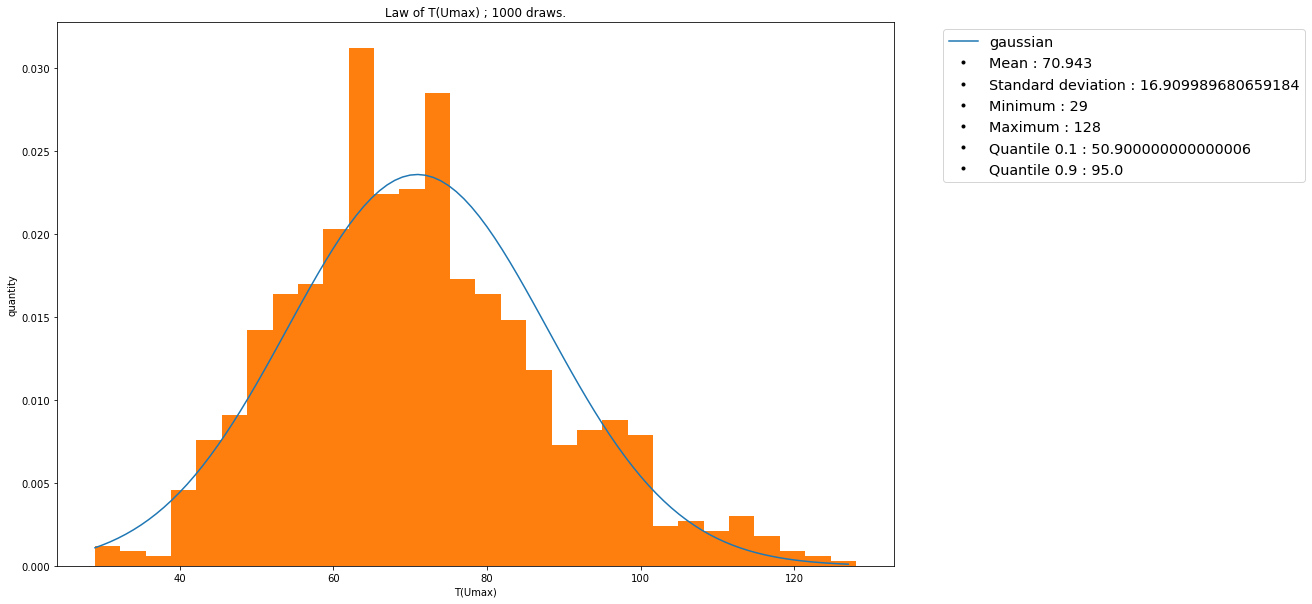

In [12]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

def get_law(array, bins, name, law = None, name_law = '', savefig = None):
    mean, std = np.mean(array), np.std(array)
    m, M = np.min(array), np.max(array)
    q10, q90 = np.quantile(array, q=0.1),np.quantile(array, q=0.9)
    
    dico = {
        'Mean' : mean,
        'Standard deviation' : std,
        'Minimum' : m,
        'Maximum' : M,
        'Quantile 0.1':q10,
        'Quantile 0.9':q90
    }
    
    N = array.shape[0]
    
    fig, ax = plt.subplots(figsize = (15,10))

    if(law!=None):
        x = np.arange(m, M)
        y = law(x, mean, std) # scale = 1/lambda = Esp(U)
        ax.plot(x,y, label = name_law)
        
    ax.hist(array, bins = bins , density = True)
    
    ax.set_title('Law of {} ; {} draws.'.format(name, N), fontsize=12)
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('quantity', fontsize=10)
    
    for key, value in dico.items():
        ax.plot([],[], '.', label = '{} : {}'.format(key, value), color = 'k')
        
    plt.legend(loc='upper left', fontsize='x-large', title_fontsize='x-small', ncol=1, bbox_to_anchor=(1.05, 1))

    if(savefig!=None):
        plt.savefig(savefig+'.png', dpi = 40)
    else:
        plt.show()

gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

get_law(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
get_law(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

## Q3) Méthode de Morris

In [ ]:
def f(input_params):
    model = SEIR(input_params)
    
    fcn = model.get_fcn()
    y_ini = model.get_state()
    # in number of days
    step_in_day = 0.5 # 1/step_in_day should be an integer
    tini = 0.
    tend = 200.0 # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini) 

    return solution

In [5]:
def Monte_Carlo_sampling(R = 100):
    list_samples = [draw_input_params() for k in range(R)]
    return np.array(list_samples)

def lhs(R = 100):
    from utils import convert
    from pyDOE2 import lhs # https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube
    lhs = lhs(15 , samples = R) # 15 dimension of the input
    # everything is in [0,1]
    
    # now putting it in the right format
    
    for k in range(R):
        lhs[k] = convert(lhs[k])
        
    return lhs
    

In [6]:
def compute_finite_diff(samples, delta, fn):
    from utils import vectorize
    delta_vect = vectorize(delta)
    arr = np.zeros(len(samples), 16) # 16 = 15 + 1
    for sample in samples:
        for d in delta_vect:
            
            df = fn(f(sample+))
        
def Morris(R = 100, delta = 1e-3, method = 'lhs'):
    if(method == 'lhs'):
        samples = lhs(R=R)
    elif(method == 'MC'):
        samples = Monte_Carlo_sampling(R=R)
    else:
        print("Method {} not recognized. \nChoices : 'lhs', 'MC'".format(method))
        return 

    
    

array([[8.91277136e-01, 1.33014255e-01, 1.56537230e-02, 1.79941275e-01,
        1.18303638e-01, 3.42247405e-01, 8.41329561e+00, 1.88901646e+01,
        1.78454421e+01, 3.39399516e+00, 7.19090386e-02, 5.00000000e+01,
        3.10000000e+01, 4.91671677e+01, 6.69118680e-03],
       [7.98237485e-01, 1.29929542e-01, 2.64726755e-02, 1.39101029e-01,
        1.63913806e-01, 3.31569472e-01, 8.56802601e+00, 2.16163380e+01,
        1.73940487e+01, 2.92025479e+00, 6.41188147e-02, 3.80000000e+01,
        2.00000000e+01, 9.99553387e+01, 8.89674894e-03],
       [5.85610096e-01, 5.42877905e-02, 2.60162941e-02, 1.06247698e-01,
        1.21029288e-01, 2.27152834e-01, 1.18511657e+01, 1.85768463e+01,
        1.85062593e+01, 3.10708087e+00, 2.19325396e-02, 4.90000000e+01,
        1.30000000e+01, 1.52175046e+01, 1.63096905e-03],
       [6.33649905e-01, 1.29202577e-01, 1.82978717e-02, 1.48721272e-01,
        1.54821265e-01, 2.58656596e-01, 8.48718144e+00, 2.39817785e+01,
        1.54424571e+01, 3.19413007e+0